In [ ]:
!pip -q install pyspark

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession, functions as F, types as T

spark = SparkSession.builder.appName("FeatureImportance").getOrCreate()
#let's load the preprocessed DS created in notebook 2
SILVER = "file:///content/drive/MyDrive/data/spotify/silver_parquet"

df = spark.read.parquet(SILVER)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The first method we use to measure which features are more related to popularity is Pearson correlation, that measures linear correlation.

In [ ]:
df.select("track_genre") \
  .where("track_genre IS NOT NULL") \
  .distinct() \
  .orderBy("track_genre") \
  .show(999, truncate=False)  # increase 999 if needed


+-----------------+
|track_genre      |
+-----------------+
|-12.753          |
|0.0898           |
|0.103            |
|0.114            |
|0.159            |
|0.34             |
|0.576            |
|0.983            |
|1                |
|1.5e-05          |
|10               |
|105.188          |
|114.211          |
|117.11           |
|121.165          |
|125.262          |
|131.721          |
|133.106          |
|133.67           |
|134.113          |
|148.759          |
|151.539          |
|3                |
|4                |
|5                |
|60.015           |
|68.453           |
|68.958           |
|7                |
|74.077           |
|76.691           |
|76.791           |
|81.078           |
|89.01            |
|89.912           |
|90.051           |
|91.467           |
|95.073           |
|acoustic         |
|afrobeat         |
|alt-rock         |
|alternative      |
|ambient          |
|anime            |
|black-metal      |
|bluegrass        |
|blues            |


In [ ]:
from pyspark.sql.functions import corr

# features list = normalized + genre
features = [
    "duration_ms", "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo",
]

target = "popularity"

# compute Pearson correlations
for f in features:
      val = df.select(corr(f, target).alias("pearson")).first()["pearson"]
      print(f"{f}: {val}")


duration_ms: -0.026089736032413775
danceability: 2.11060443564791e-06
energy: 3.163757591899276e-06
loudness: 0.00018627155268110935
speechiness: -1.607981478901234e-05
acousticness: -0.031914389896054766
instrumentalness: -8.080572887102836e-05
liveness: -1.4405304349161206e-06
valence: -0.010414153964079572
tempo: 0.00554213432165183


From the results, we can see how musical features are basically non linearly realted to popularity (all values close to 0).


Let's now see what is the most popular genre

In [ ]:
df.groupBy("track_genre") \
  .agg(F.avg("popularity").alias("avg_popularity")) \
  .orderBy(F.desc("avg_popularity")) \
  .show(20, truncate=False)


+-----------------+------------------+
|track_genre      |avg_popularity    |
+-----------------+------------------+
|pop-film         |60.43849938499385 |
|k-pop            |59.536026200873366|
|metal            |57.32327586206897 |
|chill            |55.6224279835391  |
|sad              |51.927304964539005|
|latino           |51.78894472361809 |
|grunge           |50.69257540603248 |
|indian           |50.40381991814461 |
|anime            |49.07688442211055 |
|progressive-house|48.8              |
|emo              |48.60675965665236 |
|reggaeton        |48.270270270270274|
|sertanejo        |47.823244552058114|
|deep-house       |47.54578189300412 |
|piano            |47.07808564231738 |
|ambient          |45.77527527527528 |
|brazil           |45.75613660618997 |
|hard-rock        |45.744710860366716|
|pagode           |45.57810650887574 |
|mandopop         |45.302405498281786|
+-----------------+------------------+
only showing top 20 rows



I guess it makes sense :)

Let's now train a regressor with lasso and see which are the biggest weights

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# ---- Lasso regression (no genre)
vec = VectorAssembler(inputCols=features, outputCol="features")
data = vec.transform(df.select(*features, target).dropna()).select("features", target)

train, test = data.randomSplit([0.8, 0.2], seed=42)

lasso = LinearRegression(
    featuresCol="features", labelCol=target,
    elasticNetParam=1.0, regParam=0.05,  # 1.0 = Lasso
    standardization=True                 # standardize inside model
)
model = lasso.fit(train)

# ---- metrics
pred = model.transform(test)
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"RMSE={rmse:.4f}  R2={r2:.4f}")

# ---- coefficients (importance proxy)
for name, coef in zip(features, model.coefficients.toArray()):
    print(f"{name}: {coef:.6f}")
print("Intercept:", model.intercept)


RMSE=1101.8710  R2=-3067.2639
duration_ms: -0.000008
danceability: 0.000000
energy: -0.673524
loudness: 0.000000
speechiness: 0.000000
acousticness: -2.500829
instrumentalness: 0.000215
liveness: 0.000000
valence: -1.135768
tempo: 0.000000
Intercept: 36.45107162668215


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

features_z = [
    "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
    "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
]
target = "popularity"

data_z = VectorAssembler(inputCols=features_z, outputCol="features") \
           .transform(df.select(*features_z, target).dropna()) \
           .select("features", target)

train, test = data_z.randomSplit([0.8, 0.2], seed=42)

lasso = LinearRegression(
    featuresCol="features", labelCol=target,
    elasticNetParam=1.0, regParam=0.1,  # try 0.1; adjust if needed
    standardization=False               # already using *_z
)
model = lasso.fit(train)

pred = model.transform(test)
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"RMSE={rmse:.4f}  R2={r2:.4f}")

for name, coef in zip(features_z, model.coefficients.toArray()):
    print(f"{name}: {coef:.6f}")
print("Intercept:", model.intercept)


RMSE=19.8855  R2=0.0025
duration_ms_z: -0.535006
danceability_z: 0.000000
energy_z: 0.000000
loudness_z: 0.000000
speechiness_z: 0.000000
acousticness_z: -0.666793
instrumentalness_z: 0.040327
liveness_z: 0.000000
valence_z: -0.289698
tempo_z: 0.000000
Intercept: 32.98894900336418


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# ---- features: normalized numeric + genre
features_z = [
    "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
    "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
]
target = "popularity"

# ---- stages
indexer = StringIndexer(inputCol="track_genre", outputCol="genre_idx", handleInvalid="keep")
encoder = OneHotEncoder(inputCols=["genre_idx"], outputCols=["genre_oh"], handleInvalid="keep")
assembler = VectorAssembler(inputCols=features_z + ["genre_oh"], outputCol="features")

# ---- Lasso regressor
lasso = LinearRegression(
    featuresCol="features", labelCol=target,
    elasticNetParam=1.0, regParam=0.1,  # 1.0 = Lasso
    standardization=False               # features_z already normalized
)

# ---- pipeline
pipe = Pipeline(stages=[indexer, encoder, assembler, lasso])

# ---- train/test split
train, test = df.select(*features_z, "track_genre", target).dropna().randomSplit([0.8,0.2], seed=42)

model = pipe.fit(train)
pred = model.transform(test)

# ---- evaluation
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"RMSE={rmse:.4f}  R2={r2:.4f}")


RMSE=17.3926  R2=0.2370


In [ ]:
# After fitting the pipeline as shown earlier:
stages = model.stages  # indexer, encoder, assembler, lasso
lasso_model = stages[-1]   # last stage is the LinearRegressionModel
indexer_model = stages[0]  # first stage is the StringIndexerModel

# Numeric features
numeric_coefs = list(zip(features_z, lasso_model.coefficients.toArray()[:len(features_z)]))

# Genre dummies (names come from StringIndexer labels)
genre_labels = indexer_model.labels  # list of genres in order
genre_coefs = list(zip(genre_labels, lasso_model.coefficients.toArray()[len(features_z):]))

# Print nicely
print("=== Numeric feature coefficients ===")
for name, coef in numeric_coefs:
    print(f"{name}: {coef:.6f}")

print("\n=== Genre coefficients (one-hot dummies) ===")
for name, coef in genre_coefs:
    print(f"{name}: {coef:.6f}")

print("\nIntercept:", lasso_model.intercept)


=== Numeric feature coefficients ===
duration_ms_z: -0.118611
danceability_z: 0.000000
energy_z: 0.000000
loudness_z: 0.000000
speechiness_z: 0.000000
acousticness_z: -0.518749
instrumentalness_z: 0.008735
liveness_z: 0.000000
valence_z: -0.485078
tempo_z: 0.000000

=== Genre coefficients (one-hot dummies) ===
chicago-house: -14.316675
acoustic: 0.097818
ambient: 2.925442
afrobeat: -0.885702
tango: -4.488342
sleep: 0.000000
black-metal: -5.787487
grindcore: -12.075180
forro: 0.000000
malay: 0.000000
new-age: 0.000000
bluegrass: 0.000000
cantopop: 0.000000
club: 0.000000
idm: -11.658733
alt-rock: 0.000000
deep-house: 3.888531
salsa: 0.000000
j-idol: -1.139065
children: 0.000000
anime: 5.752191
study: 0.000000
breakbeat: -7.011883
happy: -5.014672
heavy-metal: -0.159798
comedy: -1.072782
country: -7.391689
dance: -2.296181
kids: -10.855749
disney: 0.000000
iranian: -23.485331
chill: 12.265847
honky-tonk: -9.242361
drum-and-bass: 0.000000
detroit-techno: -15.190573
blues: 0.000000
disco: 

In [ ]:
# ========= ROBUST RANDOM FOREST (drop-in) =========
# Uses your same RF pipeline/params; only ensures Spark/df are usable.

from pyspark.sql import SparkSession

# 1) Ensure Spark is alive; start fresh only if needed (no change if it's already running)
try:
    spark.range(1).count()
except Exception:
    try:
        spark.stop()
    except Exception:
        pass
    spark = (SparkSession.builder
             .appName("spotify-feature-importance-rf")
             .master("local[*]")
             .config("spark.ui.showConsoleProgress", "false")
             .config("spark.driver.bindAddress", "127.0.0.1")
             .config("spark.driver.host", "127.0.0.1")
             .config("spark.driver.memory", "6g")        # bump if needed
             .config("spark.sql.shuffle.partitions", "64")
             .getOrCreate())

# 2) Make sure df is valid for THIS session; otherwise re-read just the needed columns
READ_PATH = "file:///content/drive/MyDrive/data/spotify/silver_parquet"  # adjust if your path differs
need_cols = [
    "track_genre","popularity",
    "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
    "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
]
try:
    _ = df.select(*need_cols).limit(1).count()
except Exception:
    df = (spark.read.parquet(READ_PATH)
          .select(*need_cols)
          .dropna())

# 3) Features/target (reuse if already defined; otherwise define)
try:
    features_z
except NameError:
    features_z = [
        "duration_ms_z","danceability_z","energy_z","loudness_z","speechiness_z",
        "acousticness_z","instrumentalness_z","liveness_z","valence_z","tempo_z"
    ]
target = "popularity"

# 4) Pipeline: index → one-hot → assemble → RF (same params you used)
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

idx = StringIndexer(inputCol="track_genre", outputCol="genre_idx", handleInvalid="keep")
encoder = OneHotEncoder(inputCols=["genre_idx"], outputCols=["genre_oh"], handleInvalid="keep")
assembler = VectorAssembler(inputCols=features_z + ["genre_oh"], outputCol="features")

# Define the RandomForestRegressor - you can adjust these parameters
rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=100, maxDepth=10, seed=42)

# Create the pipeline
rf_pipeline = Pipeline(stages=[idx, encoder, assembler, rf])

# Split data
train, test = df.randomSplit([0.8, 0.2], seed=42)

# Fit the model
rf_model = rf_pipeline.fit(train)

# Make predictions
pred = rf_model.transform(test)

# Evaluate the model
rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2").evaluate(pred)
print(f"Random Forest RMSE={rmse:.4f}  R2={r2:.4f}")

Random Forest RMSE=17.3048  R2=0.2457


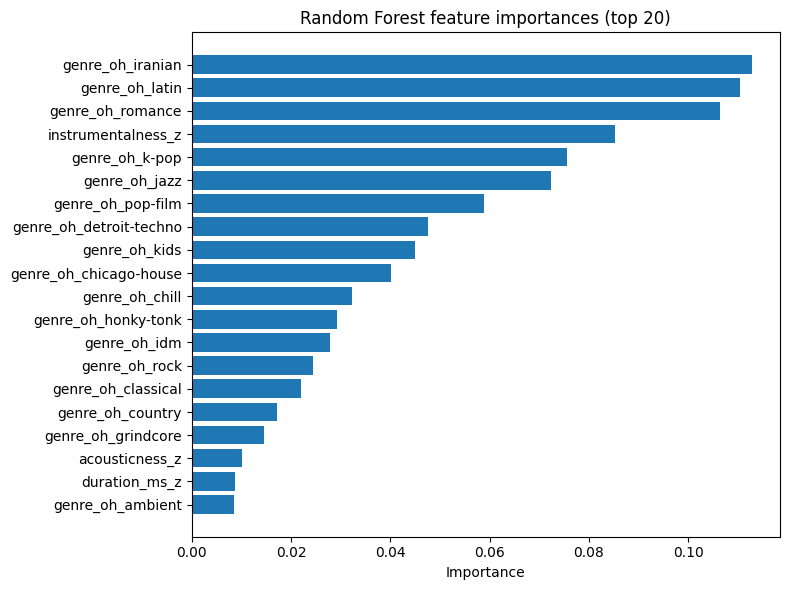

In [ ]:
# Map RF importances back to names and plot
import pandas as pd
import matplotlib.pyplot as plt

rf_stage = rf_model.stages[-1]      # RandomForestRegressionModel
assembler_model = rf_model.stages[-2] # Get the VectorAssembler model stage
encoder_model = rf_model.stages[-3] # Get the OneHotEncoder model stage
indexer_model = rf_model.stages[-4] # Get the StringIndexer model stage


importances = rf_stage.featureImportances.toArray()

# Apply the stages up to the assembler to a small sample of the training data
# to get the schema with the assembled features and their metadata.
temp_df = indexer_model.transform(train.limit(1))
temp_df = encoder_model.transform(temp_df)
assembled_temp_df = assembler_model.transform(temp_df)

# Get the feature names directly from the metadata of the assembled vector column
assembled_train_schema = assembled_temp_df.schema["features"]
feature_names = [f['name'] for f in assembled_train_schema.metadata["ml_attr"]["attrs"]["numeric"] +
                 assembled_train_schema.metadata["ml_attr"]["attrs"]["binary"]]


imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_values = imp_df.sort_values("importance", ascending=True)

# Plot top 20 by importance
top_imp = imp_df.tail(20)

plt.figure(figsize=(8, 6))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.title("Random Forest feature importances (top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# (Optional) print full ranking
# display(imp_df.sort_values("importance", ascending=False))